## Investigating edge features for high AUROC scores

My model is currently performing better than the other methods on average. My goal here is the determine which edges are performing better to determine which variables are improving the AUROC scores.

### Load the basic trained model

The best model settings for AUROC are: 
- **Model Size:** 192
- **Number of Metacells:** 10k
- **Number of Attention Heads:** 8
- **Number of Attention Layers:** 3

In [137]:
import pandas as pd
import torch
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
from typing import Tuple

import dev.auroc_testing as auroc_testing

EXPERIMENT_DIR = Path("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments/mESC_no_scale_linear")
GROUND_TRUTH_DIR = Path("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/data/ground_truth_files")

base_model_dir = EXPERIMENT_DIR / "model_training_192_15k_metacells"

model_file = base_model_dir / "trained_model.pt"
training_log_file = base_model_dir / "training_log.csv"

tf_ko_count_file = base_model_dir / "tf_tg_fullmodel_knockout_count.npy"
tf_ko_score_file = base_model_dir / "tf_tg_fullmodel_knockout.npy"

tf_grad_attrib_file = base_model_dir / "tf_tg_grad_attribution.npy"

tf_tg_vocab_file = base_model_dir / "tf_tg_vocab_id2name.pt"

### Load experiment info

In [138]:
import importlib

importlib.reload(auroc_testing)

<module 'dev.auroc_testing' from '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/auroc_testing.py'>

In [139]:
def load_gradient_attribution_matrix(selected_experiment_dir, tf_names, tg_names):
    # --- load gradient attribution matrix ---
    grad = np.load(selected_experiment_dir / "tf_tg_grad_attribution.npy")  # shape [T, G]
    assert grad.shape == (len(tf_names), len(tg_names))

    # Optional: handle NaNs
    grad = np.nan_to_num(grad, nan=0.0)

    # Use absolute gradient magnitude as importance
    grad_abs = np.abs(grad)

    # Row-wise z-score per TF (ignore NaNs if you keep them)
    row_mean = grad_abs.mean(axis=1, keepdims=True)
    row_std  = grad_abs.std(axis=1, keepdims=True) + 1e-6
    grad_z = (grad_abs - row_mean) / row_std   # [T, G]

    # Build long-form dataframe
    T, G = grad_z.shape
    tf_idx, tg_idx = np.meshgrid(np.arange(T), np.arange(G), indexing="ij")

    gradient_attrib_df = pd.DataFrame({
        "Source": np.array(tf_names, dtype=object)[tf_idx.ravel()],
        "Target": np.array(tg_names, dtype=object)[tg_idx.ravel()],
        "Score": grad_z.ravel(),
    })
    gradient_attrib_df["Source"] = gradient_attrib_df["Source"].astype(str).str.upper()
    gradient_attrib_df["Target"] = gradient_attrib_df["Target"].astype(str).str.upper()
    
    return gradient_attrib_df

In [140]:
tf_names, tg_names = auroc_testing.load_vocab(base_model_dir)
gradient_attrib_df = load_gradient_attribution_matrix(base_model_dir, tf_names, tg_names)
tf_ko_df = auroc_testing.load_tf_knockout_scores(base_model_dir, tf_names, tg_names)

In [141]:
print(tf_names[:5])

['2810021J22RIK', '4930522L14RIK', 'AEBP2', 'AHR', 'AHRR']


### Ground Truth Files

In [142]:
ground_truth_file_dict = {
    "ChIP-Atlas": GROUND_TRUTH_DIR / "chip_atlas_tf_peak_tg_dist.csv",
    "RN111": GROUND_TRUTH_DIR / "RN111.tsv",
    "RN112": GROUND_TRUTH_DIR / "RN112.tsv",
    "RN114": GROUND_TRUTH_DIR / "RN114.tsv",
    "RN115": GROUND_TRUTH_DIR / "RN115.tsv",
    "RN116": GROUND_TRUTH_DIR / "RN116.tsv",
}

gt_edges_dict = {}
gt_tf_dict = {}
gt_tg_dict = {}
for i, (gt_name, ground_truth_file) in enumerate(ground_truth_file_dict.items(), start=1):
    print(f"Loading {gt_name} ({i}/{len(ground_truth_file_dict)})")

    gt_analysis_dir = base_model_dir / f"{gt_name}_analysis"
    os.makedirs(gt_analysis_dir, exist_ok=True)

    # --- Ground truth & sets ---
    ground_truth_df = auroc_testing.load_ground_truth(ground_truth_file)

    chip_valid = ground_truth_df[
        ground_truth_df["Source"].isin(tf_names)
        & ground_truth_df["Target"].isin(tg_names)
    ]
    
    gt_edges = set(zip(chip_valid["Source"], chip_valid["Target"]))
    gt_tfs   = set(chip_valid["Source"])
    gt_tgs   = set(chip_valid["Target"])
    
    gt_edges_dict[gt_name] = gt_edges
    gt_tf_dict[gt_name] = gt_tfs
    gt_tg_dict[gt_name] = gt_tgs

Loading ChIP-Atlas (1/6)
Loading RN111 (2/6)
Loading RN112 (3/6)
Loading RN114 (4/6)
Loading RN115 (5/6)
Loading RN116 (6/6)


In [143]:
gradient_attrib_df.head()

,Source,Target,Score
0,2810021J22RIK,0610005C13RIK,-0.339651
1,2810021J22RIK,0610009E02RIK,-0.545847
2,2810021J22RIK,0610030E20RIK,-0.525312
3,2810021J22RIK,1110002J07RIK,-0.581331
4,2810021J22RIK,1110019D14RIK,-0.137447


### Per Ground Truth AUROC and AUPRC

Computing metrics for ChIP-Atlas...
Computing metrics for RN111...
Computing metrics for RN112...
Computing metrics for RN114...
Computing metrics for RN115...
Computing metrics for RN116...

=== Method Ranking ===
                      mean_auroc  std_auroc  mean_auprc  std_auprc  n_gt
name                                                                    
Gradient Attribution    0.544392   0.013989    0.537591   0.016957     6
TF Knockout             0.517060   0.028846    0.527882   0.017703     6


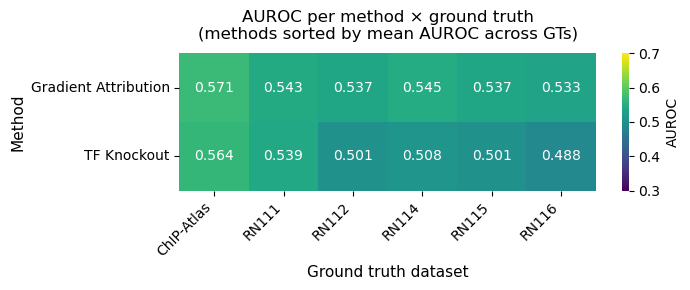

In [144]:
method_dict_base = {
    "Gradient Attribution": gradient_attrib_df,  # Original, unfiltered
    "TF Knockout": tf_ko_df                       # Original, unfiltered
}

all_method_results = []

# Loop through each ground truth dataset
for gt_name, ground_truth_file in ground_truth_file_dict.items():
    print(f"Computing metrics for {gt_name}...")
    
    # Load THIS ground truth's edges and gene sets
    ground_truth_df = auroc_testing.load_ground_truth(ground_truth_file)
    
    # Get TFs and TGs that are actually in your model
    chip_valid = ground_truth_df[
        ground_truth_df["Source"].isin(tf_names) &
        ground_truth_df["Target"].isin(tg_names)
    ]
    gt_edges = set(zip(chip_valid["Source"], chip_valid["Target"]))
    gt_tfs = set(chip_valid["Source"])
    gt_tgs = set(chip_valid["Target"])
    
    # Filter and label for THIS specific ground truth
    for method_name, method_df in method_dict_base.items():
        # Filter to THIS GT's gene set
        filtered_df = auroc_testing.filter_df_to_gene_set(
            method_df.copy(), 
            gt_tfs,  # THIS GT's TFs only
            gt_tgs   # THIS GT's TGs only
        )
        
        # Label with THIS GT's edges
        labeled_df = auroc_testing.label_edges(filtered_df, gt_edges)
        
        # labeled_df["Score"] = labeled_df["Score"].abs()
        
        # Compute AUROC/AUPRC
        res = auroc_testing.compute_curves(
            labeled_df,
            score_col="Score",
            label_col="is_gt",  # Standard label column
            balance=True,
            name=method_name,
        )
        
        if res is not None:
            res["gt_name"] = gt_name
            res["sample"] = "POOLED"
            all_method_results.append(res)

# Convert to DataFrame
df_results = pd.DataFrame(all_method_results)

# Compute method ranking
method_rank = (
    df_results
    .groupby("name")
    .agg(
        mean_auroc=("auroc", "mean"),
        std_auroc=("auroc", "std"),
        mean_auprc=("auprc", "mean"),
        std_auprc=("auprc", "std"),
        n_gt=("gt_name", "nunique"),
    )
    .sort_values("mean_auroc", ascending=False)
)

print("\n=== Method Ranking ===")
print(method_rank)

auroc_heat_fig = auroc_testing.plot_method_gt_heatmap(df_results, metric="auroc")
auroc_heat_fig.show()

### Per-TF metrics

In [145]:
method_dict_base = {
    "Gradient Attribution": gradient_attrib_df,
    "TF Knockout": tf_ko_df
}

per_tf_all_results = []

# Loop through each ground truth dataset
for gt_name, ground_truth_file in ground_truth_file_dict.items():
    print(f"Computing per-TF metrics for {gt_name}...")
    
    # Load THIS ground truth's edges and gene sets
    ground_truth_df = auroc_testing.load_ground_truth(ground_truth_file)
    
    # Get TFs and TGs that are actually in your model
    chip_valid = ground_truth_df[
        ground_truth_df["Source"].isin(tf_names) &
        ground_truth_df["Target"].isin(tg_names)
    ]
    gt_edges = set(zip(chip_valid["Source"], chip_valid["Target"]))
    gt_tfs = set(chip_valid["Source"])
    gt_tgs = set(chip_valid["Target"])
    
    # Compute per-TF metrics for each method
    for method_name, method_df in method_dict_base.items():
        # Filter to THIS GT's gene set
        filtered_df = auroc_testing.filter_df_to_gene_set(
            method_df.copy(), 
            gt_tfs,
            gt_tgs
        )
        
        # Label with THIS GT's edges
        labeled_df = auroc_testing.label_edges(filtered_df, gt_edges)
        
        # Compute per-TF metrics
        per_tf_df = auroc_testing.compute_per_tf_metrics(
            labeled_df,
            score_col="Score",
            label_col="is_gt",
            tf_col="Source",
            min_edges=10,
            min_pos=1,
            balance=True,
        )
        
        if per_tf_df.empty:
            print(f"  No valid TFs for {method_name} in {gt_name}")
            continue
        
        # Add metadata
        per_tf_df["method"] = method_name
        per_tf_df["gt_name"] = gt_name
        
        per_tf_all_results.append(per_tf_df)
        print(f"  {method_name}: {len(per_tf_df)} TFs")

# Concatenate all results
per_tf_metrics = pd.concat(per_tf_all_results, ignore_index=True)

print(f"\n=== Per-TF Metrics Summary ===")
print(f"Total rows: {len(per_tf_metrics)}")
print(f"Unique TFs: {per_tf_metrics['tf'].nunique()}")
print(f"Methods: {per_tf_metrics['method'].unique()}")
print(f"Ground truths: {per_tf_metrics['gt_name'].unique()}")

# Save detailed per-TF metrics
per_tf_metrics.to_csv("per_tf_auroc_auprc_detailed.csv", index=False)
print("\nSaved: per_tf_auroc_auprc_detailed.csv")

Computing per-TF metrics for ChIP-Atlas...
  Gradient Attribution: 58 TFs
  TF Knockout: 58 TFs
Computing per-TF metrics for RN111...
  Gradient Attribution: 34 TFs
  TF Knockout: 31 TFs
Computing per-TF metrics for RN112...
  Gradient Attribution: 23 TFs
  TF Knockout: 23 TFs
Computing per-TF metrics for RN114...
  Gradient Attribution: 18 TFs
  TF Knockout: 18 TFs
Computing per-TF metrics for RN115...
  Gradient Attribution: 23 TFs
  TF Knockout: 23 TFs
Computing per-TF metrics for RN116...
  Gradient Attribution: 12 TFs
  TF Knockout: 10 TFs

=== Per-TF Metrics Summary ===
Total rows: 331
Unique TFs: 88
Methods: ['Gradient Attribution' 'TF Knockout']
Ground truths: ['ChIP-Atlas' 'RN111' 'RN112' 'RN114' 'RN115' 'RN116']

Saved: per_tf_auroc_auprc_detailed.csv


In [146]:
# 1) Average across TFs within each (method, ground truth)
method_gt_avg = (
    per_tf_metrics
    .groupby(['method', 'gt_name'], as_index=False)
    .agg(
        auroc=('auroc', 'mean'),
        auprc=('auprc', 'mean'),
        n_tfs=('tf', 'nunique'),
    )
)

print("\n=== Per-TF AUROC by Method and Ground Truth ===")
print(method_gt_avg.pivot(index='method', columns='gt_name', values='auroc').round(3))

# 2) Average across ground truths for each method
method_rank_per_tf = (
    method_gt_avg
    .groupby('method')
    .agg(
        mean_auroc=('auroc', 'mean'),
        std_auroc=('auroc', 'std'),
        mean_auprc=('auprc', 'mean'),
        std_auprc=('auprc', 'std'),
        n_gt=('gt_name', 'nunique'),
    )
    .sort_values('mean_auroc', ascending=False)
)

print("\n=== Method Ranking by Per-TF AUROC ===")
print(method_rank_per_tf)

method_rank_per_tf.to_csv("method_ranking_per_tf.csv")


=== Per-TF AUROC by Method and Ground Truth ===
gt_name               ChIP-Atlas  RN111  RN112  RN114  RN115  RN116
method                                                             
Gradient Attribution       0.609  0.571  0.538  0.574  0.538   0.57
TF Knockout                0.585  0.559  0.494  0.543  0.494   0.52

=== Method Ranking by Per-TF AUROC ===
                      mean_auroc  std_auroc  mean_auprc  std_auprc  n_gt
method                                                                  
Gradient Attribution    0.566719   0.026304    0.575295   0.033278     6
TF Knockout             0.532663   0.036510    0.554438   0.029964     6


In [147]:
# 1) Per-dataset summary
dataset_summary = (
    per_tf_metrics
    .groupby(['method', 'gt_name'])
    .agg({
        'auroc': ['mean', 'median', 'std', 'min', 'max'],
        'tf': 'count'
    })
    .round(3)
)
dataset_summary.columns = ['_'.join(col).strip('_') for col in dataset_summary.columns]
print("\n=== Per-Dataset Summary ===")
print(dataset_summary)

# 2) Per-TF summary across datasets
tf_summary = (
    per_tf_metrics
    .groupby(['method', 'tf'])
    .agg({
        'auroc': ['mean', 'std'],
        'gt_name': 'count'
    })
    .round(3)
)
tf_summary.columns = ['_'.join(col).strip('_') for col in tf_summary.columns]
tf_summary = tf_summary.reset_index()

# Show top TFs for each method
print("\n=== Top 20 TFs by AUROC ===")
for method in per_tf_metrics['method'].unique():
    print(f"\n{method}:")
    top_tfs = tf_summary[tf_summary['method'] == method].nlargest(20, 'auroc_mean')
    print(top_tfs[['tf', 'auroc_mean', 'auroc_std', 'gt_name_count']].to_string(index=False))


=== Per-Dataset Summary ===
                                 auroc_mean  auroc_median  auroc_std  \
method               gt_name                                           
Gradient Attribution ChIP-Atlas       0.609         0.611      0.040   
                     RN111            0.571         0.574      0.083   
                     RN112            0.538         0.530      0.053   
                     RN114            0.574         0.557      0.068   
                     RN115            0.538         0.530      0.053   
                     RN116            0.570         0.560      0.235   
TF Knockout          ChIP-Atlas       0.585         0.587      0.079   
                     RN111            0.559         0.544      0.056   
                     RN112            0.494         0.513      0.118   
                     RN114            0.543         0.539      0.052   
                     RN115            0.494         0.513      0.118   
                     RN116         

In [148]:
import importlib

importlib.reload(auroc_testing)

<module 'dev.auroc_testing' from '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/auroc_testing.py'>


Saved boxplots: per_tf_auroc_boxplot.png, per_tf_auprc_boxplot.png


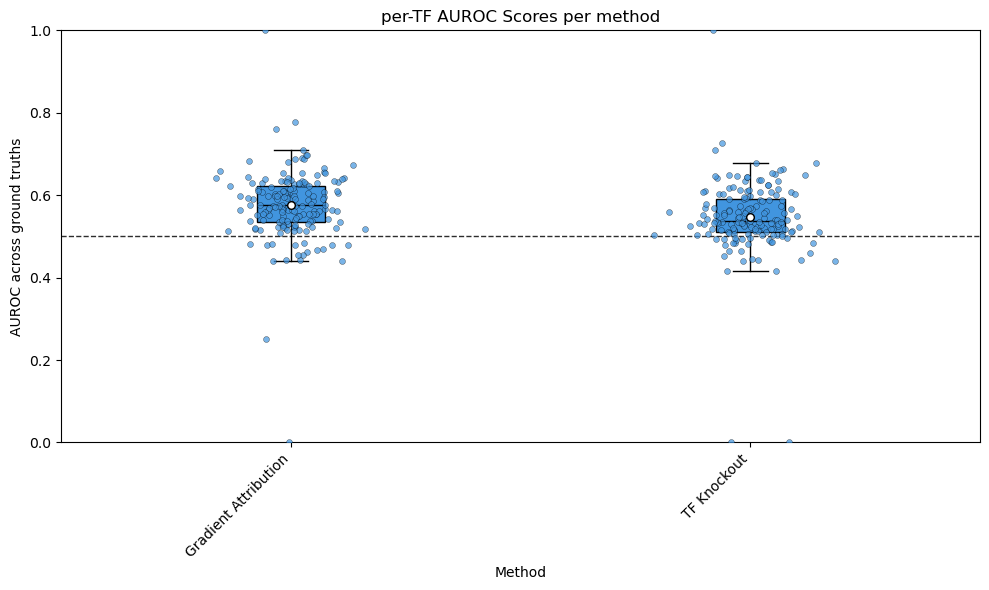

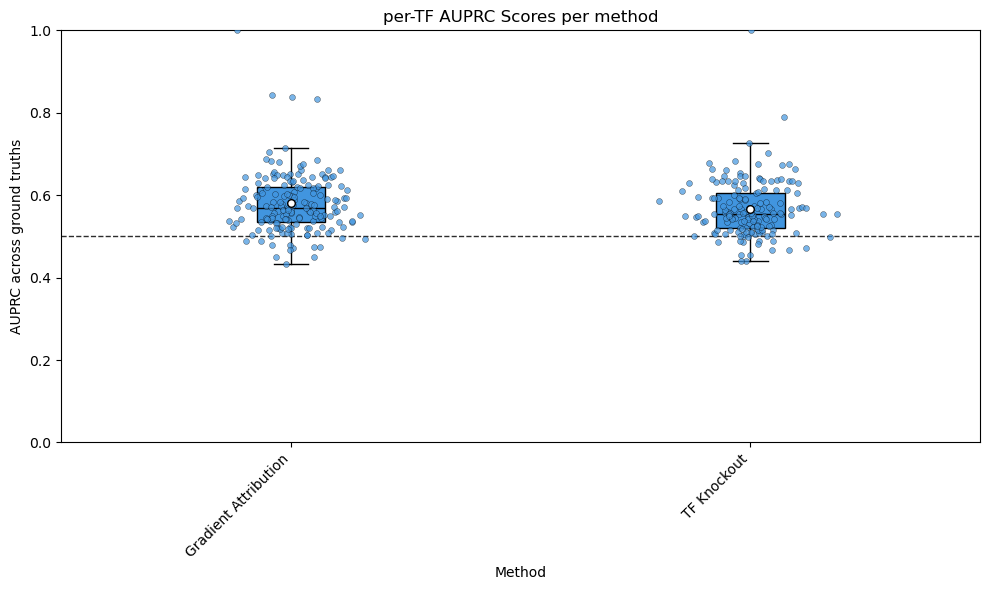

In [149]:
# Format for boxplot functions
per_tf_for_plot = per_tf_metrics[['method', 'auroc', 'auprc']].copy()
per_tf_for_plot = per_tf_for_plot.rename(columns={'method': 'name'})

# Create boxplots
per_tf_auroc_boxplot = auroc_testing.plot_all_results_auroc_boxplot(per_tf_for_plot, per_tf=True)
per_tf_auprc_boxplot = auroc_testing.plot_all_results_auprc_boxplot(per_tf_for_plot, per_tf=True)

per_tf_auroc_boxplot.savefig("per_tf_auroc_boxplot.png", dpi=300, bbox_inches='tight')
per_tf_auprc_boxplot.savefig("per_tf_auprc_boxplot.png", dpi=300, bbox_inches='tight')

print("\nSaved boxplots: per_tf_auroc_boxplot.png, per_tf_auprc_boxplot.png")

In [152]:
# Create comparison table
comparison = pd.DataFrame({
    'method': method_rank['name'] if 'name' in method_rank.columns else method_rank.index,
    'pooled_auroc': method_rank['mean_auroc'].values,
    'per_tf_auroc': method_rank_per_tf.loc[method_rank.index, 'mean_auroc'].values,
})
comparison['difference'] = comparison['per_tf_auroc'] - comparison['pooled_auroc']

print("\n=== Pooled vs Per-TF AUROC Comparison ===")
print(comparison)


=== Pooled vs Per-TF AUROC Comparison ===
                 method  pooled_auroc  per_tf_auroc  difference
0  Gradient Attribution      0.544392      0.566719    0.022327
1           TF Knockout      0.517060      0.532663    0.015603


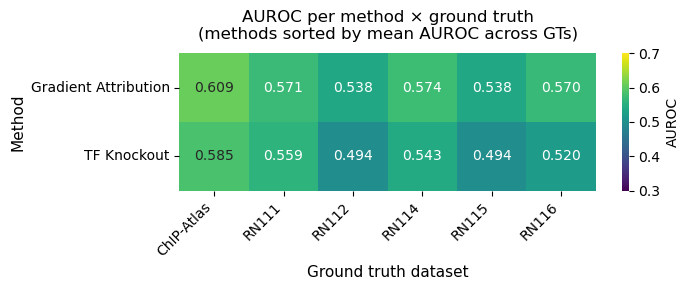

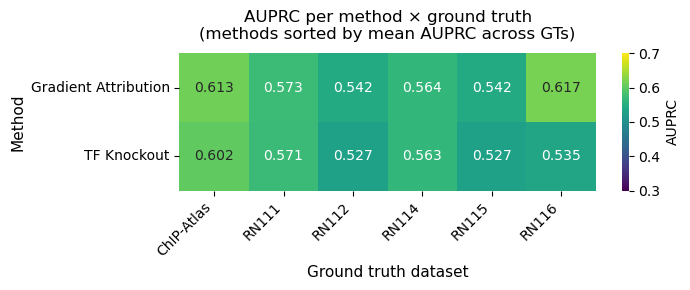

In [153]:
# Prepare data for heatmap (needs 'name' column instead of 'method')
per_tf_heatmap_data = method_gt_avg.copy()
per_tf_heatmap_data = per_tf_heatmap_data.rename(columns={'method': 'name'})
per_tf_heatmap_data['sample'] = 'PER_TF'

# Create AUROC heatmap
per_tf_auroc_heatmap = auroc_testing.plot_method_gt_heatmap(
    per_tf_heatmap_data, 
    metric="auroc"
)
per_tf_auroc_heatmap.show()

# Create AUPRC heatmap
per_tf_auprc_heatmap = auroc_testing.plot_method_gt_heatmap(
    per_tf_heatmap_data, 
    metric="auprc"
)

per_tf_auprc_heatmap.show()


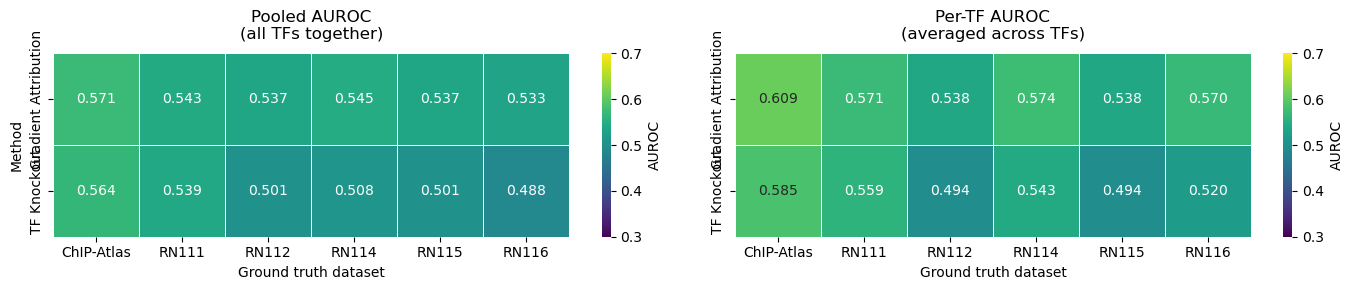

In [155]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_pooled_vs_per_tf_comparison(df_pooled, per_tf_heatmap_data, metric="auroc"):
    """Create side-by-side heatmaps comparing pooled vs per-TF metrics."""
    
    metric = metric.lower()
    
    # Get method order (by per-TF mean)
    method_order = (
        per_tf_heatmap_data.groupby("name")[metric]
        .mean()
        .sort_values(ascending=False)
        .index
        .tolist()
    )
    
    # Pivot both datasets
    pooled_heat = df_pooled.pivot_table(
        index="name", columns="gt_name", values=metric
    ).loc[method_order]
    
    per_tf_heat = per_tf_heatmap_data.pivot_table(
        index="name", columns="gt_name", values=metric
    ).loc[method_order]
    
    # Create side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 3))
    
    # Pooled heatmap
    sns.heatmap(
        pooled_heat,
        annot=True,
        fmt=".3f",
        cmap="viridis",
        vmin=0.3,
        vmax=0.7,
        cbar_kws={"label": metric.upper()},
        linewidths=0.5,
        linecolor='white',
        ax=ax1,
    )
    ax1.set_title(f"Pooled {metric.upper()}\n(all TFs together)", fontsize=12, pad=10)
    ax1.set_xlabel("Ground truth dataset", fontsize=10)
    ax1.set_ylabel("Method", fontsize=10)
    
    # Per-TF heatmap
    sns.heatmap(
        per_tf_heat,
        annot=True,
        fmt=".3f",
        cmap="viridis",
        vmin=0.3,
        vmax=0.7,
        cbar_kws={"label": metric.upper()},
        linewidths=0.5,
        linecolor='white',
        ax=ax2,
    )
    ax2.set_title(f"Per-TF {metric.upper()}\n(averaged across TFs)", fontsize=12, pad=10)
    ax2.set_xlabel("Ground truth dataset", fontsize=10)
    ax2.set_ylabel("")
    
    plt.tight_layout()
    return fig

# Create comparison
comparison_fig = plot_pooled_vs_per_tf_comparison(
    df_results,  # pooled results
    per_tf_heatmap_data,  # per-TF results
    metric="auroc"
)
comparison_fig.show()

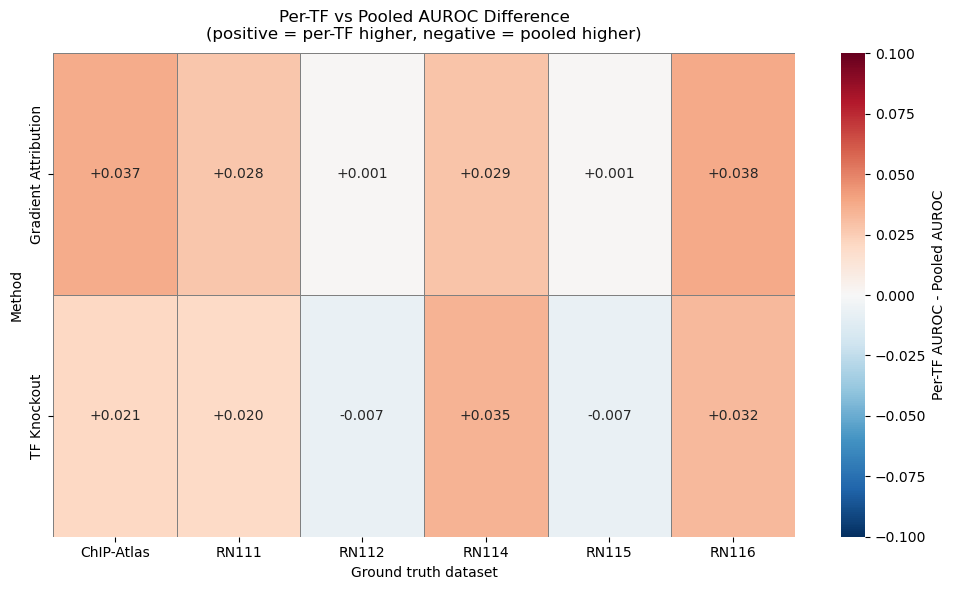

In [159]:
def plot_per_tf_minus_pooled_heatmap(df_pooled, per_tf_heatmap_data, metric="auroc"):
    """Create heatmap showing per-TF AUROC minus pooled AUROC."""
    
    metric = metric.lower()
    
    # Pivot both datasets
    pooled_heat = df_pooled.pivot_table(
        index="name", columns="gt_name", values=metric
    )
    
    per_tf_heat = per_tf_heatmap_data.pivot_table(
        index="name", columns="gt_name", values=metric
    )
    
    # Calculate difference
    diff_heat = per_tf_heat - pooled_heat
    
    # Sort by mean difference
    mean_diff = diff_heat.mean(axis=1).sort_values(ascending=False)
    diff_heat = diff_heat.loc[mean_diff.index]
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.heatmap(
        diff_heat,
        annot=True,
        fmt="+.3f",  # Show + for positive differences
        cmap="RdBu_r",  # Red = higher per-TF, Blue = higher pooled
        center=0,
        vmin=-0.1,
        vmax=0.1,
        cbar_kws={"label": f"Per-TF {metric.upper()} - Pooled {metric.upper()}"},
        linewidths=0.5,
        linecolor='gray',
        ax=ax,
    )
    
    ax.set_title(
        f"Per-TF vs Pooled {metric.upper()} Difference\n"
        f"(positive = per-TF higher, negative = pooled higher)",
        fontsize=12,
        pad=10
    )
    ax.set_xlabel("Ground truth dataset", fontsize=10)
    ax.set_ylabel("Method", fontsize=10)
    
    plt.tight_layout()
    return fig

# Create difference heatmap
diff_fig = plot_per_tf_minus_pooled_heatmap(
    df_results,
    per_tf_heatmap_data,
    metric="auroc"
)
diff_fig.show()